# Imports and  preprocessing

_We import all the libraries needed_

In [ ]:
import matplotlib.pyplot as plt
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

_We setup paths and variables like image and batch size._

In [ ]:
train_dir = pathlib.Path('dataset/train')
test_dir = pathlib.Path('dataset/test')
val_dir = pathlib.Path('dataset/val')

height = 300
width = 300
batch_size = 32

_We create 3 datasets: one for train, one for test and the last one for validation.  
In each dataset, images are split up in 2 classes: healthy and sick._

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    color_mode= "grayscale",
    seed=123,
    image_size=(height, width),
    batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    color_mode= "grayscale",
    seed=123,
    image_size=(height, width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    color_mode= "grayscale",
    seed=123,
    image_size=(height, width),
    batch_size=batch_size)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


_We load dataset in cache so the algorithm could access it faster._

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model

_To prevent overfitting we increase the dataset by doing some prepocessing work.  
The last function is to speed up the calculations._

In [6]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",input_shape=(height, width, 1)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.Rescaling(1./255),
  ]
)

_The model consists of five convolution blocks with a max pool layer in each of them. There's a fully connected layer with 512 units on top of it that is activated by a relu activation function and we had dropout to prevent overfitting.  
Finally we compile the model using adam optimizer, binary crossentropy as loss and accuracy as metrics._

In [7]:
model = Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 300, 300, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 300, 300, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)       

_Finally we run the model with 100 epochs_

In [ ]:
epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

# Displaying data

_We display accuracy and loss for both training and validation._

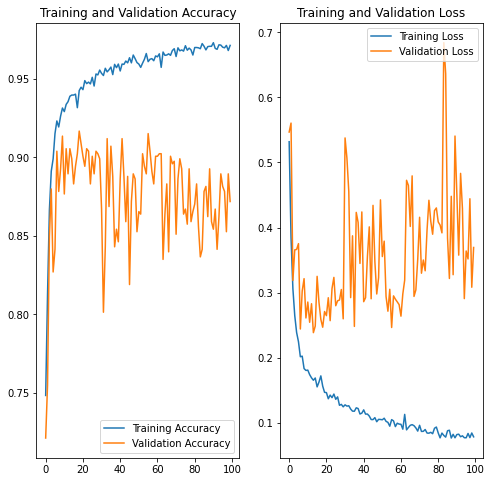

0.9375


In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

print(max(history.history['val_accuracy']))

# Testing

We can test our model by giving it a random image from the test dataset. In this case, the model correctly predicts the image as healthy with a confidence of 100%.

In [8]:
img = keras.preprocessing.image.load_img(
    'dataset/test/NORMAL/NORMAL2-IM-0130-0001.jpeg',
    color_mode= "grayscale",
    target_size=(height, width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to NORMAL with a 100.00 percent confidence.
